# AD SIMULATION

We will modify the JansenRit model and the connectome in order to simulate an EEG

The first thing we need to do, is to import the necessary TVB modules and some additional Python packages to perform the simulation and analyze our results.

In [1]:
# Online visualization.
%pylab nbagg

# Import tvb library.
import numpy as np
import tvb.simulator.lab as tvb
from tvb.basic.neotraits.api import Final, List
from tvb.simulator.lab import *
from tvb.datatypes import graph
from tvb.datatypes.time_series import TimeSeriesRegion 
from tvb.analyzers.info import sampen
import tvb.simulator.plot.power_spectra_interactive as ps_int

# Import a bunch of stuff to ease command line usage.
from scipy.stats import entropy, chi2_contingency, circvar, pearsonr, ttest_ind
from scipy import signal
from scipy.signal import butter, lfilter, freqz, hilbert, coherence, filtfilt, welch
from scipy.special import xlogy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time as tm


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


WARNING  File 'hemispheres' not found in ZIP.


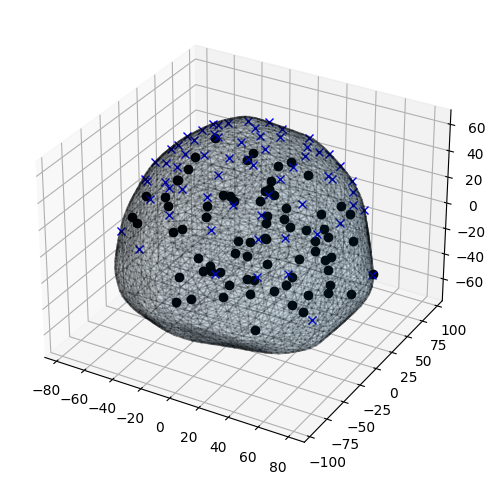

In [2]:
%matplotlib inline

sens_meg = sensors.SensorsMEG.from_file()
conn =  connectivity.Connectivity.from_file('connectivity_76.zip')
skin = surfaces.SkinAir.from_file()
skin.configure()
sens_eeg = sensors.SensorsEEG.from_file()
sens_eeg.configure()
mon_EEG = monitors.EEG.from_file()

n_channels = len(mon_EEG.sensors.labels)
n_regions = len(conn.centres)

figure(figsize = (6,6))
ax = subplot(111, projection='3d')
# Plot cortical regions as black dots:
x, y, z = conn.centres.T[:,:]
ax.plot(x, y, z, 'ko')

# Plot EEG sensors as blue x's:
x, y, z = sens_eeg.sensors_to_surface(skin).T
ax.plot(x, y, z, 'bx')


# Plot boundary surface
x, y, z = skin.vertices.T
ax.plot_trisurf(x, y, z, triangles=skin.triangles, alpha=0.1, edgecolor='k')


In [3]:
from tvb.basic.neotraits.api import NArray, Attr

#Define important constants
sim_time = 30000
period = 1.
noiseval = 5e-3
###########################################################

#This will inject the virtual stimulus in wanted regions
class MultiStimuliRegion(patterns.StimuliRegion):
    connectivity = Attr(connectivity.Connectivity, required=False)
    temporal = Attr(field_type=equations.TemporalApplicableEquation, required=False)
    weight = NArray(required=False)
    
    def __init__(self, *stimuli):
        super(MultiStimuliRegion, self).__init__()
        self.stimuli = stimuli
    def configure_space(self, *args, **kwds):
        [stim.configure_space(*args, **kwds) for stim in self.stimuli]
    def configure_time(self, *args, **kwds):
        [stim.configure_time(*args, **kwds) for stim in self.stimuli]
    def __call__(self, *args, **kwds):
        return np.array([stim(*args, **kwds) for stim in self.stimuli]).sum(axis=0)
    


def make_train(node_idx, node_weights, con=conn, stimweight = 1, **params):
    
    nnode = conn.weights.shape[0]
    weighting = np.zeros(nnode)
    weighting[node_idx] = node_weights
    eqn_t = equations.PulseTrain()
    eqn_t.parameters.update(params)
    stimulus = patterns.StimuliRegion(
        temporal=eqn_t,
        connectivity=conn,
        weight=weighting)
    return stimulus




def mean_channels(mask1, mask2, signal, chlist):
    summ = 0
    for ch in chlist:
        summ += signal[mask1:mask2, 0, ch, 0]
    summ /= len(chlist)
    return summ

def std_channels(mask1, mask2, signal, chlist):
    summ = 0
    mean = mean_channels(mask1, mask2, signal, chlist)
    for ch in chlist:
        summ += (signal[mask1:mask2, 0, ch, 0] - mean)**2
    #summ = sqrt(summ)
    summ /= len(chlist)-1
    return summ

# Generate data

Data will be generated from a network that uses for each node a modified JansenRit model that takes into account Abeta formation and accumulation, while the connectome will be adjusted to the empirical observations about amyloid-induced degeneration of brain connections:

In [5]:
#Load Connectivity matrix
#conn =  connectivity.Connectivity.from_file('connectivity_76.zip')

#define impaired regions (taken from Braak stages)
impaired_regions = [9, 21, 22, 30, 31, 32, 34, 59, 60, 62, 68, 69, 70, 72]
#######################################################################

#This function modifies connective weights by means of a parameter weightval
def alter_connectivity(disconnection, con = conn, regions = impaired_regions, neuroplasticity = 2):

    # Specify row and column indices
    rows = regions
    columns = regions

    #Connections to weaken:
    # Adjust connectivity in rows
    for row in rows:
        con.weights[row] -= np.ones((76)) * disconnection

    # Adjust connectivity in columns
    for col in columns:
        con.weights[:, col] -= np.ones((76)) * disconnection


    # Define connections to strengthen (neuroplasticity)
    connections = [
        # Hyppo amyg
        [(9, 9), (2, 2), (62, 62), (40, 40)],
        [(9, 24), (2, 24), (40, 62), (37, 62), (38, 62)],
        [(24, 9), (24, 2), (62, 40), (62, 37), (62, 38)],
        # Self
        [(21, 21), (22, 22), (30, 30), (31, 31), (32, 32), (34, 34), (59, 59),
         (60, 60), (68, 68), (69, 69), (70, 70), (72, 72)],
        # Cross left hemisphere
        [(21, 34), (21, 33), (21, 16), (34, 33), (34, 6), (34, 8), (34, 16),
         (22, 24), (22, 26), (30, 9), (30, 17), (30, 27), (30, 17), (31, 8),
         (31, 10), (31, 11), (32, 9), (32, 29)],
        [(34, 21), (31, 21), (16, 21), (33, 34), (6, 34), (8, 34), (16, 34),
         (24, 22), (26, 22), (9, 30), (17, 30), (27, 30), (17, 30), (8, 31),
         (10, 31), (11, 31), (9, 32), (29, 32)],
        # Cross right hemisphere
        [(59, 44), (59, 46), (59, 48), (59, 58), (59, 44), (59, 70), (60, 58),
         (68, 39), (68, 47), (68, 49), (68, 69), (68, 71), (68, 72), (69, 47),
         (69, 62), (69, 74), (70, 40), (70, 46), (70, 48), (70, 49), (72, 47),
         (72, 74)],
        [(44, 59), (46, 59), (48, 59), (58, 59), (44, 59), (70, 59), (58, 60),
         (39, 68), (47, 68), (49, 68), (69, 68), (71, 68), (72, 68), (47, 69),
         (62, 69), (74, 69), (40, 70), (46, 70), (48, 70), (49, 70), (47, 72),
         (74, 72)]
    ]

    # Update connections with weightval
    for connection in connections:
        for row, col in connection:
            con.weights[row][col] += (neuroplasticity * disconnection)



    np.matrix.clip(con.weights, 0, 3, out=con.weights)

    return con




def Simulate(weightval, aval, bval, regions = impaired_regions, con = conn, 
             stimulus_bool = False, stimweight = 5,sim_time = sim_time):

    con = alter_connectivity(weightval, con = con)

    con.weights = con.weights / np.max(con.weights)              #normalised by maximum weight  
    con.speed = np.array([np.inf])                               #no time delays => velocity ->∞
    con.configure()


    #altering inhibition in impaired regions:
    b = np.ones(76)*0.048
    b [regions]  = np.ones(len(regions)) * bval


    # setup model based on paper's parameters
    model_pars = dict(
        A=3.25,
        B=22,
        v0=6.0,
        a=aval, # increased with respect to the healthy case. (also remember that TVB uses ms, not s)
        b=b,    # decreased with respect to the healthy case. (also remember that TVB uses ms, not s)
        r=0.56,
        nu_max=0.0025, # e0 in the JR original paper
        # TVB factors C_i into J*a_i, e.g. C1 = a_1 * J
        J=135,
        a_1=1.0,
        a_2=0.8,
        a_3= 0.25,
        a_4= 0.25,
        mu=0.22, # avg of 120 and 320 pulses/s
    )

    # implement JR + afferent PSP
    class JRPSP(tvb.models.JansenRit):
        state_variable_range = Final(
            default={"y0": np.array([-1.0, 1.0]),
                     "y1": np.array([-500.0, 500.0]),
                     "y2": np.array([-50.0, 50.0]),
                     "y3": np.array([-6.0, 6.0]),
                     "y4": np.array([-20.0, 20.0]),
                     "y5": np.array([-500.0, 500.0]),
                     "y6": np.array([-20.0, 20.0]),
                     "y7": np.array([-500.0, 500.0])})

        variables_of_interest = List(
            of=str,
            label="Variables watched by Monitors",
            choices=("y0", "y1", "y2", "y3", "y4", "y5", "y6", "y7"),
            default=("y0", "y1", "y2", "y3"))

        state_variables = tuple('y0 y1 y2 y3 y4 y5 y6 y7'.split())
        _nvar = 8
        cvar = np.array([6], dtype=np.int32)

        def dfun(self, state_variables, coupling, local_coupling=0.0):
            dy = np.zeros((8, state_variables.shape[1], 1))
            # TVB's JR is eq 6 only
            dy[:6] = super().dfun(state_variables[:6], coupling, local_coupling)
            # tack on PSP for efferent following eq 8
            # NB with this, only y12 is coupling var for TVB
            y0, y1, y2, y3, y4, y5, y6, y7 = state_variables
            a_d = self.a / 3.0
            sigm_y1_y2 = 2.0 * self.nu_max / (1.0 + np.exp(self.r * (self.v0 - (y1 - y2))))
            dy[6] = y7
            dy[7] = self.A * a_d * sigm_y1_y2 - 2.0 * a_d * y7 - self.a**2 * y6
            return dy

    # factor out noise from dy4 = A a (p(t) + ...) as y4 += dt (...) + A a dW_t
    # this allows us to model the noise as TVB does it, though scaling requires experiment
    nsig = np.zeros((8, 76, 1))
    nsig[4] = model_pars['A'] * model_pars['a'] * (.320 - .120) * 100e-3
    noise = tvb.noise.Additive(nsig=nsig)

    #setting up monitors:
    mon_tavg = monitors.TemporalAverage(period=period)
    mon_EEG.period=period
    #Bundling
    what_to_watch = (mon_tavg, mon_EEG)


    if stimulus_bool == True:
        '''
        Now we define the regions (e.g. 35,73), stimulus intensity (stimweight), 
        time at onset (onset), period (T) and duration (tau).

        Regions are: (Ventral Visual pathway)

        # 35, 73 v1
        # 36, 74 v2
        # 34, 72 temporal ventraL
        # 32, 70 temporal pole
        # 24, 62 phippocampal 
        '''

        train1 = make_train([35,73], stimweight, con = con, onset=500, T=1000.0, tau=40.0)
        train2 = make_train([36,74], stimweight, con = con, onset=600, T=1000, tau=50.0)
        train3 = make_train([34,72], stimweight, con = con, onset=700, T=1000, tau=80.0)
        train4 = make_train([32,70], stimweight, con = con, onset=800, T=1000, tau=80.0)
        train5 = make_train([24,62], stimweight, con = con, onset=900, T=1000, tau=80.0)
        stimulus = MultiStimuliRegion(train1, train2,train3, train4, train5)
        stimulus.configure_space()
        time = r_[1e3:3e3:15.0]
        stimulus.configure_time(time)
        pattern = stimulus()

    else:
        stimulus = None




    sim = simulator.Simulator(connectivity=con,
                              conduction_speed=np.float(con.speed),
                              model=JRPSP(
                              variables_of_interest=("y0", "y1", "y2", "y3", "y4", "y5", "y6", "y7"),
                              **{k: np.array(v) for k, v in model_pars.items()}),
                              coupling=tvb.coupling.Linear(a=np.r_[aval*10]),
                              integrator=tvb.integrators.EulerStochastic(dt=0.1, noise=noise),
                              #coupling=coupling.SigmoidalJansenRit(a=numpy.array([10.0])),
                              #integrator=integrators.HeunStochastic(dt=2 ** -4, noise=noise.Additive(nsig=sigma)),
                              #monitors=(monitors.TemporalAverage(period=1),), #period in ms
                              monitors=what_to_watch,
                              stimulus = stimulus,
                              simulation_length=sim_time)
    sim.configure()

    (ttavg, tavg), (teeg, eeg) = sim.run(simulation_length=sim_time)

    return ttavg, tavg, teeg, eeg
                           
                           
def preprocess(ttavg, tavg, teeg, eeg, PSD = True, normalize = True):

    if PSD:
        #Discarding initial transient for PSD analysis
        ttavg = ttavg[1000:]
        tavg = tavg[1000:, :, :, :]
                           
        teeg = teeg[1000:]
        eeg = eeg[1000:, :, :, :]
        
        ttavg -= 1000
        teeg -= 1000

    if normalize:
        tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
        tavg -= np.mean(tavg, 0)
        eeg /= (np.max(eeg,0) - np.min(eeg,0 ))
        eeg -= np.mean(eeg, 0)
                           
    return ttavg, tavg, teeg, eeg

# Simulated signals

Here we define parameters and feed them into the Simulate function to simulate electrophysiological activity. We will store and analyze both temporal average (tavg) of post-synaptic potential (PSP) and EEG. The tavg, being computed as a sum of AMPA-ergic EPSP and GABAa-ergic IPSP, can be seen as a mean-field proxy of the Local Field Potential.

WARNING  File 'hemispheres' not found in ZIP.
   INFO  Projection configured gain shape (65, 76)


C:\Users\tnela\AppData\Local\Temp\ipykernel_13644\3962368975.py:179: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conduction_speed=np.float(con.speed),
C:\Users\tnela\OneDrive\Desktop\LGA\TVB\TVB_Distribution\tvb_data\Lib\site-packages\numba\np\ufunc\gufunc.py:170: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
C:\Users\tnela\AppData\Local\Temp\ipykernel_13644\3962368975.py:129: RuntimeWarning: overflow encountered in exp
  sigm_y1_y2 = 2.0 * self.nu_max / (1.0 + np.exp(self.r * (self.v0 - (y1 - y2))))


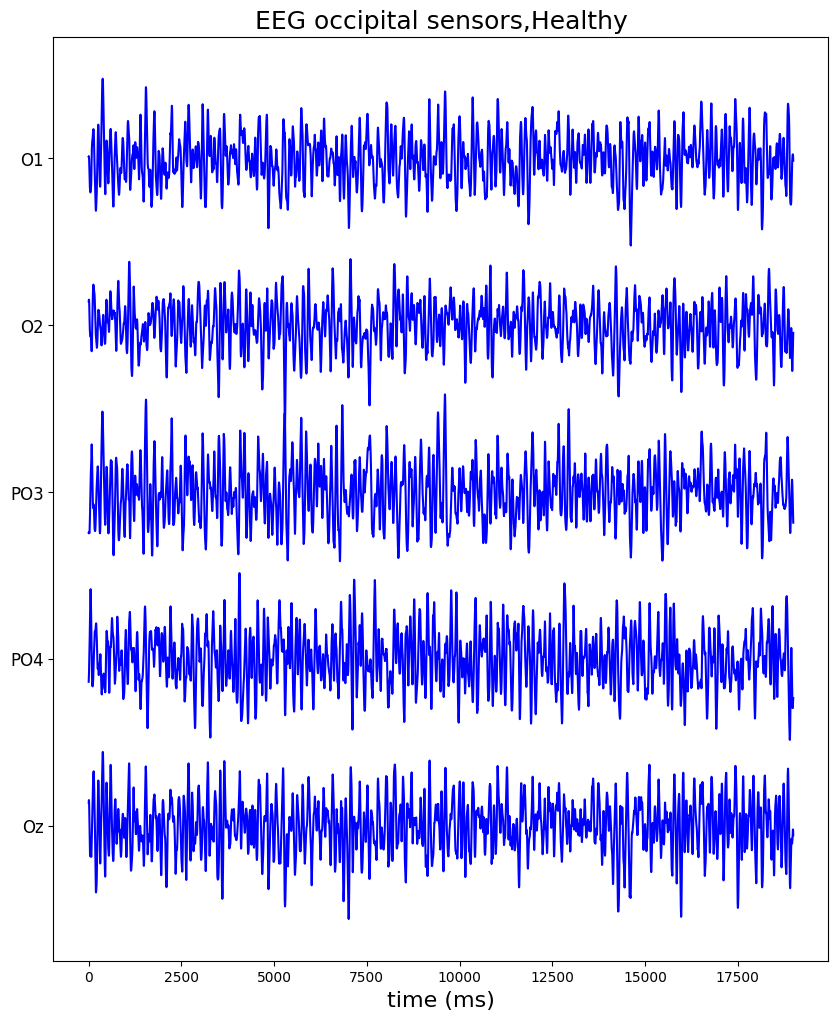

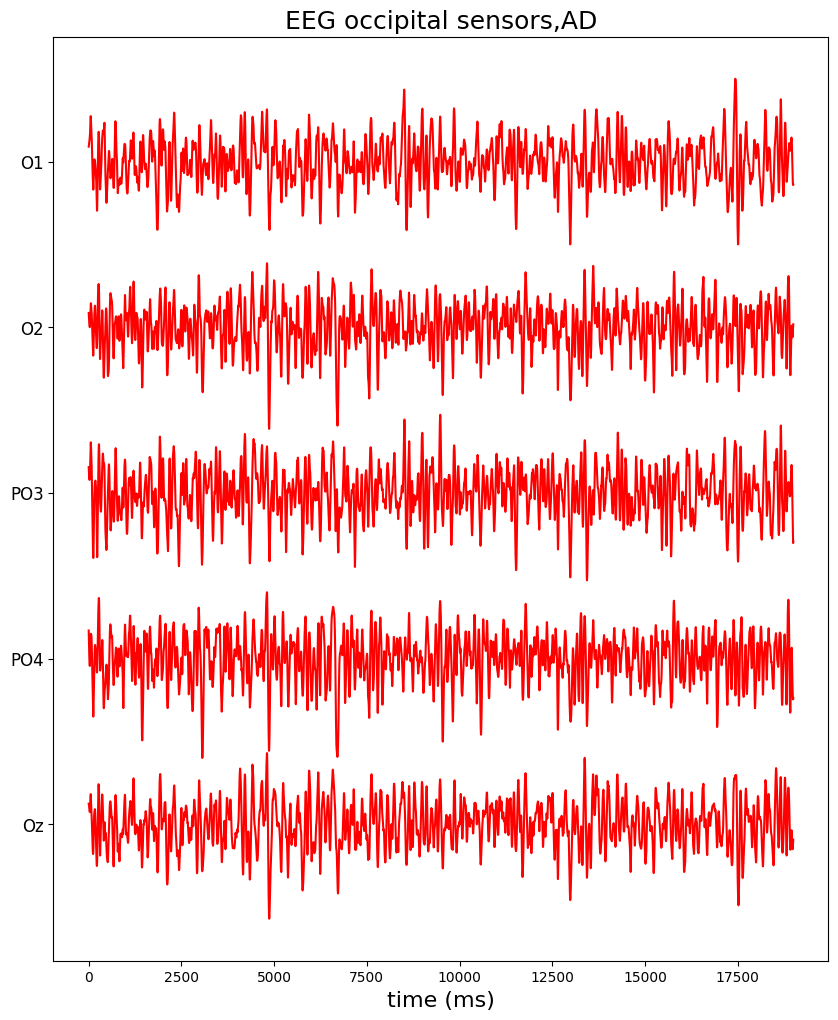

In [6]:
#Load Connectivity
conn =  connectivity.Connectivity.from_file('connectivity_76.zip')

#We determine model parameters as explained in the paper (eqs 2 and 3)
n_steps = 50
weightval_arr = np.linspace(0,2,n_steps)
aval_arr = np.linspace(0.100,0.112,n_steps)
bval_arr = np.linspace(0.048,0.025,n_steps)


ttavg, tavg_healthy, teeg, eeg_healthy = Simulate(weightval = weightval_arr[15] , aval = aval_arr[26], bval = bval_arr[26], 
                                                  con = conn, stimulus_bool = False, sim_time = 20000)
ttavg, tavg_healthy, teeg, eeg_healthy = preprocess(ttavg, tavg_healthy, teeg, eeg_healthy)


ttavg, tavg_AD, teeg, eeg_AD = Simulate(weightval = weightval_arr[49] , aval = aval_arr[49], bval = bval_arr[49], 
                                        con = conn, stimulus_bool = False, sim_time = 20000)
ttavg, tavg_AD, teeg, eeg_AD = preprocess(ttavg, tavg_AD, teeg, eeg_AD)



datas = {'data_healthy': {'tavg': tavg_healthy, 'eeg': eeg_healthy, 'label': 'Healthy', 'color': 'blue'},
         'data_AD': {'tavg': tavg_AD, 'eeg': eeg_AD,  'label': 'AD', 'color': 'red'}}

#Occipital EEG channels
chlist_occipital = [30,32,33,8,9]
display_time = sim_time - 2000



for key, value in datas.items():
    tavg = value['tavg']
    eeg = value['eeg']
    label = value['label']
    color = value['color']

    #Plot EEG
    figure(figsize=(10,12))
    plot(teeg[:display_time], eeg[:display_time, 0, chlist_occipital, 0] + np.r_[:(len(chlist_occipital))], color = color)
    yticks(np.r_[:len(chlist_occipital)], mon_EEG.sensors.labels[chlist_occipital], fontsize = 12)
    title("EEG occipital sensors," + label, fontsize = 18)
    plt.xlabel('time (ms)', fontsize = 16)
    plt.show()



# Functional Connectivity

In here we will compute functional connectivity between brain regions and/or EEG electrodes.

###  Compute FC
The results of the simulation are stored as a  **4D-array**.
We need to turn it into one of TVB's time series datatypes, which is what the interactive plotting tool operate on, in this case we are using **TimeSeriesRegion** (i.e., region-based simulation).


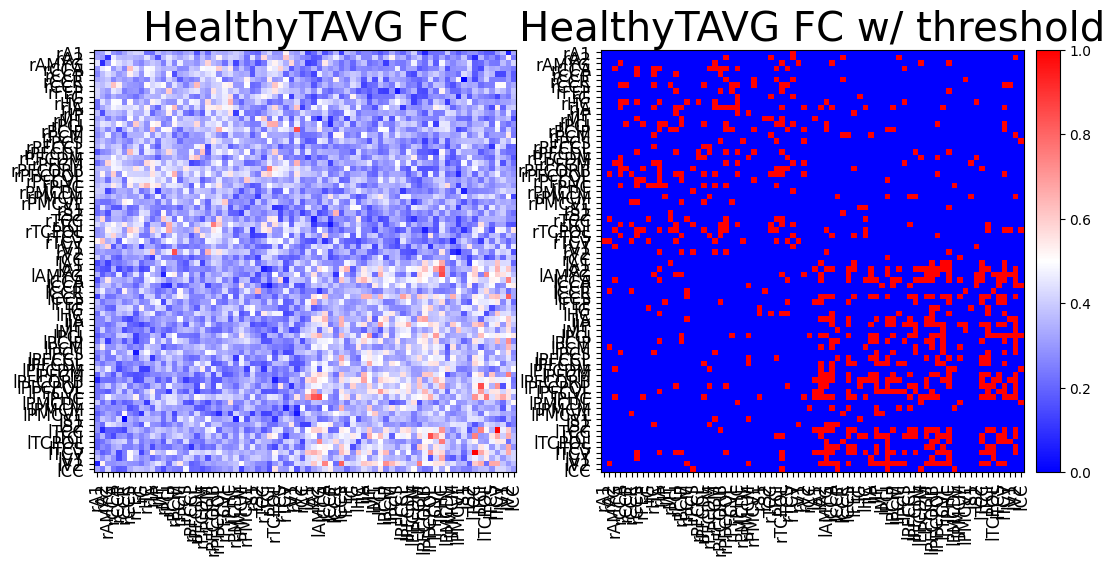

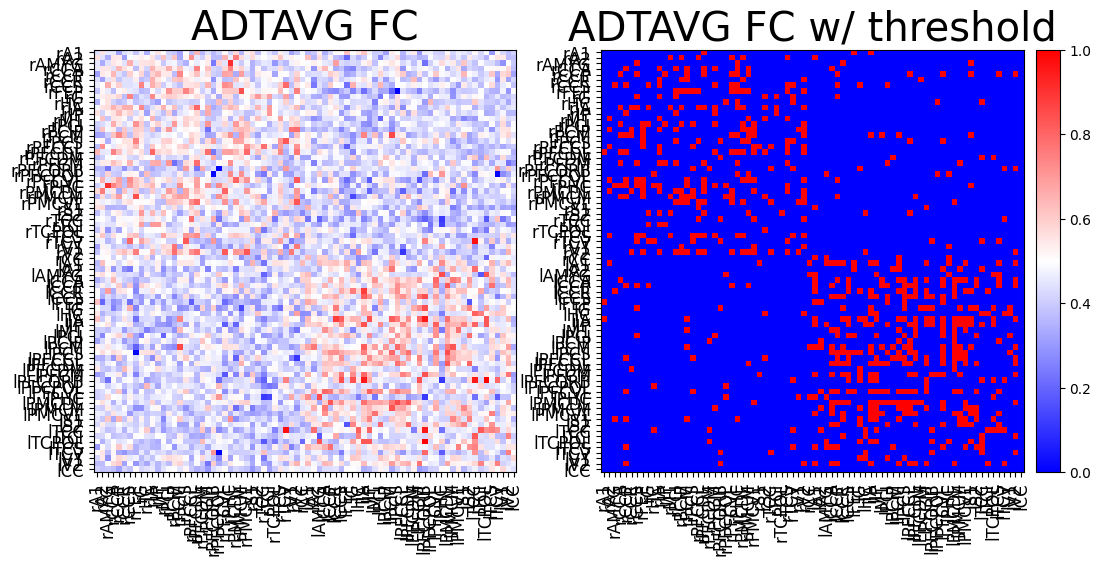

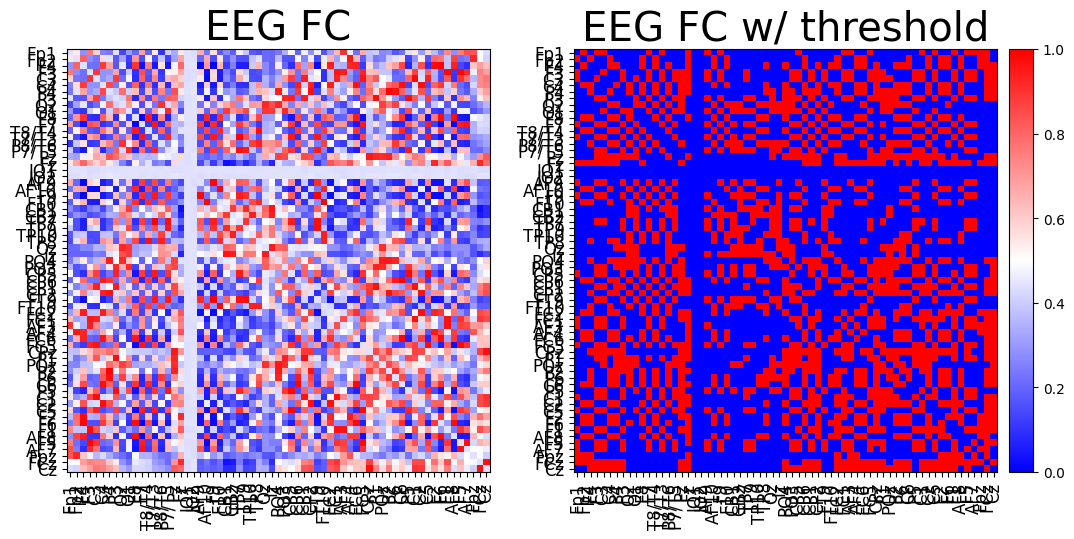

In [7]:
#Define a function to compute Functional Connectivity
def ev(time_series):
    
    tsr = TimeSeriesRegion(connectivity=conn,
                       data=time_series[:,:,:,:],                            #in TVB 4D format
                       sample_period=period) #in ms
    tsr.configure()
    
    input_shape = tsr.data.shape
    result_shape = (input_shape[2], input_shape[2], input_shape[1], input_shape[3])
    result = numpy.zeros(result_shape)

    for mode in range(result_shape[3]):
        for var in range(result_shape[2]):
            data = tsr.data[:,var,:, mode].squeeze()
            result[:, :, var, mode] = numpy.corrcoef(data.T)

    corr_coeff = graph.CorrelationCoefficients(source=tsr, array_data=result)
    
    return corr_coeff

def functional_connectivity(time_series, th=0.08):

    tsr_corr = ev(time_series)

    corr= tsr_corr.array_data[..., 0, 0]
    
    corr -= np.eye(len(time_series[0,0,:,0]))

    #Define a threshold for connections
    th = th 

    corr_th = corr> th

    pmatrix = np.zeros((len(time_series[0,0,:,0]),len(time_series[0,0,:,0])))

    for i in range(len(time_series[0,0,:,0])):
        for j in range(len(time_series[0,0,:,0])):
            pmatrix[i][j] = pearsonr(time_series[:,0, i, 0], time_series[:,0, j, 0])[1]

    pmatrix_th = pmatrix < 0.05

    corr_th_significance = np.multiply(corr_th, pmatrix_th)

    return corr, corr_th_significance


for key, value in datas.items():
    tavg = value['tavg']
    eeg = value['eeg']
    label = value['label']
    color = value['color']

    corr_tavg, corr_tavg_th = functional_connectivity(tavg)
    corr_eeg, corr_eeg_th = functional_connectivity(eeg)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    # Plot corr_tavg
    im1 = ax1.imshow(corr_tavg, interpolation='nearest', cmap='bwr')
    ax1.set_yticks(np.arange(len(conn.region_labels)))
    ax1.set_yticklabels(conn.region_labels, fontsize=12)
    ax1.set_xticks(np.arange(len(conn.region_labels)))
    ax1.set_xticklabels(conn.region_labels, rotation='vertical', fontsize=12)
    ax1.set_title(label+'TAVG FC', fontsize=29)

    # Plot corr_tavg_th
    im2 = ax2.imshow(corr_tavg_th, interpolation='nearest', cmap='bwr')
    ax2.set_yticks(np.arange(len(conn.region_labels)))
    ax2.set_yticklabels(conn.region_labels, fontsize=12)
    ax2.set_xticks(np.arange(len(conn.region_labels)))
    ax2.set_xticklabels(conn.region_labels, rotation='vertical', fontsize=12)
    ax2.set_title(label+'TAVG FC w/ threshold', fontsize=29)

    # Colorbar
    cax = fig.add_axes([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])
    cbar = plt.colorbar(im2, cax=cax)

    plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Plot corr_eeg
im1 = ax1.imshow(corr_eeg, interpolation='nearest', cmap='bwr')
ax1.set_yticks(np.arange(len(mon_EEG.sensors.labels)))
ax1.set_yticklabels(mon_EEG.sensors.labels, fontsize=12)
ax1.set_xticks(np.arange(len(mon_EEG.sensors.labels)))
ax1.set_xticklabels(mon_EEG.sensors.labels, rotation='vertical', fontsize=12)
ax1.set_title('EEG FC', fontsize=29)

# Plot corr_eeg_th
im2 = ax2.imshow(corr_eeg_th, interpolation='nearest', cmap='bwr')
ax2.set_yticks(np.arange(len(mon_EEG.sensors.labels)))
ax2.set_yticklabels(mon_EEG.sensors.labels, fontsize=12)
ax2.set_xticks(np.arange(len(mon_EEG.sensors.labels)))
ax2.set_xticklabels(mon_EEG.sensors.labels, rotation='vertical', fontsize=12)
ax2.set_title('EEG FC w/ threshold', fontsize=29)

# Colorbar
cax = fig.add_axes([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])
cbar = plt.colorbar(im2, cax=cax)

plt.show()


## Compute power spectrum



## PSD WELCH:

Now we will display PSD of the distribution(s) using Welch method. 
Firstly, we will obtain and plot the mean time series of TAVG and EEG, 
later we will generate the band-passed version of the Power spectrum 
calculated with Welch method.

C:\Users\tnela\AppData\Local\Temp\ipykernel_13644\3988523993.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(freqs_tavg, psd_tavg_mean, 'r', label = label, linewidth = 4, color = color)
C:\Users\tnela\AppData\Local\Temp\ipykernel_13644\3988523993.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(freqs_eeg, psd_eeg_mean, 'r', label = label, linewidth = 4, color = color)
C:\Users\tnela\AppData\Local\Temp\ipykernel_13644\3988523993.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,0,10,20,30,40], fontsize = 20)
C:\Users\tnela\AppData\Local\Temp\ipykernel_13644\3988523993.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.

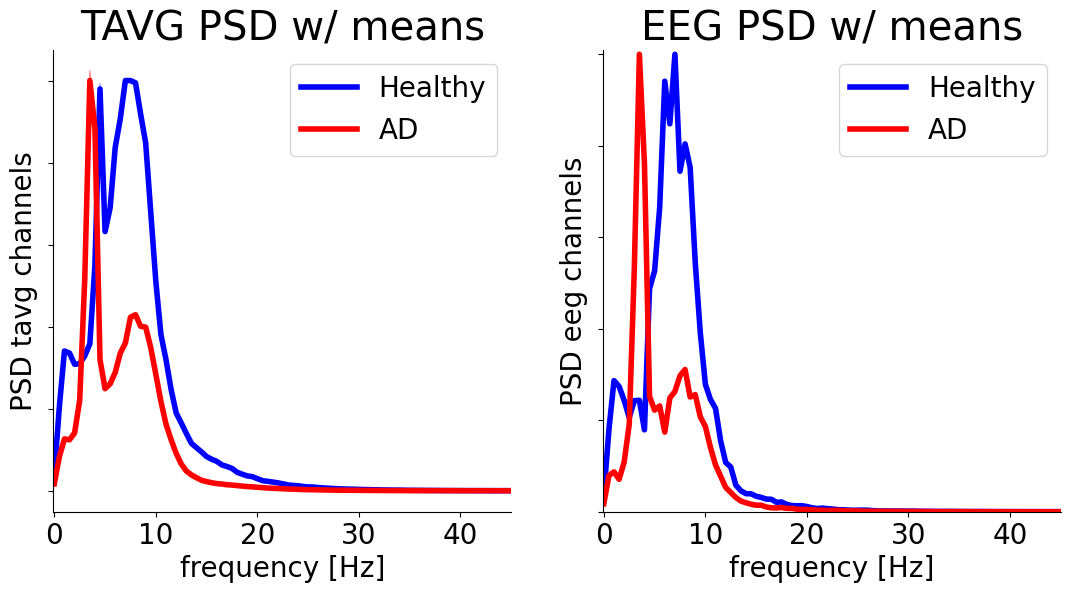

In [8]:


freq_sample = 1024



lowcut = 0.5
highcut = 45
order = 4

n_seg = 2048
freq_sample = n_seg//2
freq = freq_sample+1 
window = 'hamming'



def filter_bandpass(signal, lowcut, highcut, fs):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    signal_bp = filtfilt(b, a, signal, axis = 0)
    return signal_bp


def compute_psd(time_series): 
    
    signal_bp = np.zeros((len(time_series[:,0,0,0]), len(time_series[0,0,:,0])))


    Welch_signal_bp = np.zeros((freq, freq, len(time_series[0,0,:,0])))
    
    for i in range (len(time_series[0,0,:,0])):
        signal_bp[:,i] = filter_bandpass(time_series[:,0,i,0], lowcut, highcut, freq_sample)
        Welch_signal_bp[:, 0, i], Welch_signal_bp[0, :, i] = signal.welch(signal_bp[:,i],
                                                                                    freq_sample, nperseg=n_seg, 
                                                                                    noverlap=n_seg//2, window=window)
        
    
    welch_mean = np.mean(Welch_signal_bp[0, :, :], axis = 1)
    welch_mean /= np.max(welch_mean) #Normalize
    welch_sem =  np.std(Welch_signal_bp[0, :, :], axis = 1)
    welch_sem /= np.max(welch_mean) #Normalize
    
    return Welch_signal_bp[:, 0, 0], welch_mean, welch_sem
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    
for key, value in datas.items():
    tavg = value['tavg']
    eeg = value['eeg']
    label = value['label']
    color = value['color']
    
    
    freqs_tavg, psd_tavg_mean, psd_tavg_sem = compute_psd(tavg)
    freqs_eeg, psd_eeg_mean, psd_eeg_sem = compute_psd(eeg)
    
    ax1.plot(freqs_tavg, psd_tavg_mean, 'r', label = label, linewidth = 4, color = color)
    ax1.fill_between(freqs_tavg, psd_tavg_mean + psd_tavg_sem, psd_tavg_mean - psd_tavg_sem, where = None, alpha = 0.35,  color = color)
    
    ax2.plot(freqs_eeg, psd_eeg_mean, 'r', label = label, linewidth = 4, color = color)
    ax2.fill_between(freqs_eeg, psd_eeg_mean + psd_eeg_sem, psd_eeg_mean - psd_eeg_sem, where = None, alpha = 0.35, color = color)

    
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('TAVG PSD w/ means', fontsize = 29)
ax2.set_ylim(0, 1.01)
ax1.set_xlim(-0.1, 45)
ax1.set_xlabel('frequency [Hz]', fontsize = 20)
ax1.set_ylabel('PSD tavg channels', fontsize = 20)
ax1.set_xticklabels([0,0,10,20,30,40], fontsize = 20)
ax1.set_yticklabels([], fontsize = 20)
ax1.legend(fontsize = 20)
#ax1.set_yscale('log')


ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title('EEG PSD w/ means', fontsize = 29)
ax2.set_ylim(0, 1.01)
ax2.set_xlim(-0.1, 45)
ax2.set_xlabel('frequency [Hz]', fontsize = 20)
ax2.set_ylabel('PSD eeg channels', fontsize = 20)
ax2.set_xticklabels([0,0,10,20,30,40], fontsize = 20)
ax2.set_yticklabels([], fontsize = 20)
ax2.legend(fontsize = 20)
#ax2.set_yscale('log')

plt.show()  

# Stimulus Evoked Response Potential (ERP) analysis:

Here we have a brief code for displaying the depth of the N1 ERP component, taken from occipital channels, and the magnitude of P2 ERP component, taken from central channels. 
Both quantities correlate with cognitive performance.


WARNING  File 'hemispheres' not found in ZIP.


C:\Users\tnela\AppData\Local\Temp\ipykernel_13644\3962368975.py:179: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conduction_speed=np.float(con.speed),
C:\Users\tnela\AppData\Local\Temp\ipykernel_13644\3962368975.py:129: RuntimeWarning: overflow encountered in exp
  sigm_y1_y2 = 2.0 * self.nu_max / (1.0 + np.exp(self.r * (self.v0 - (y1 - y2))))


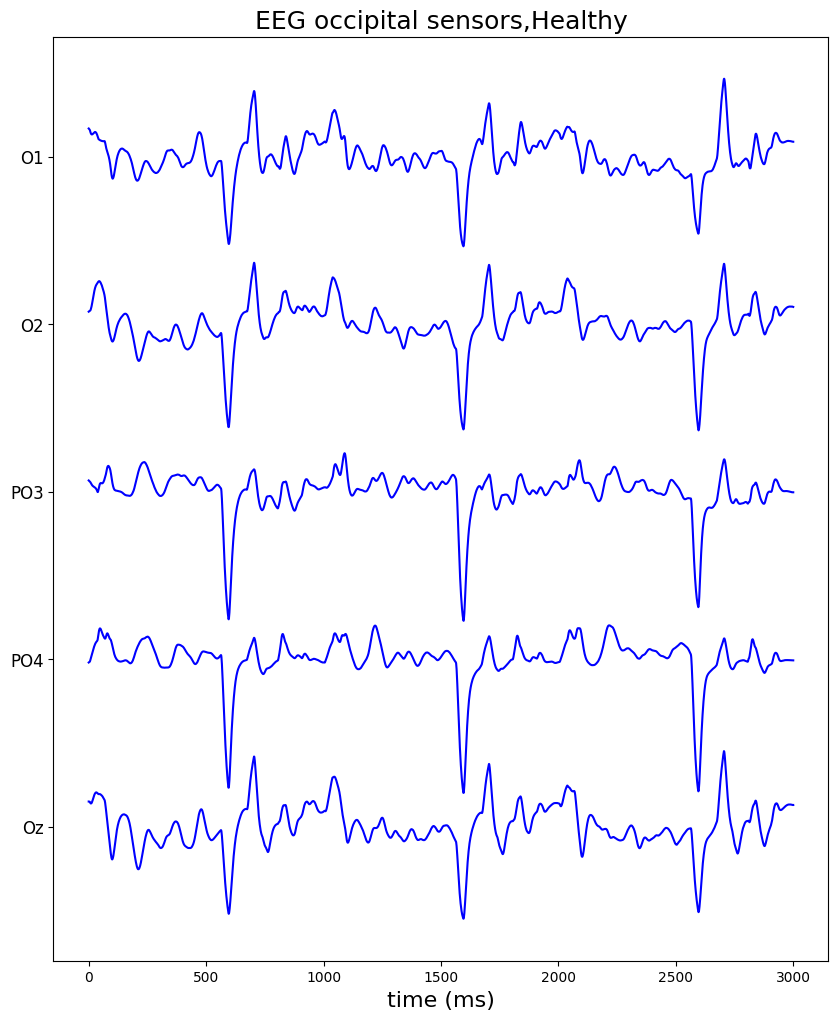

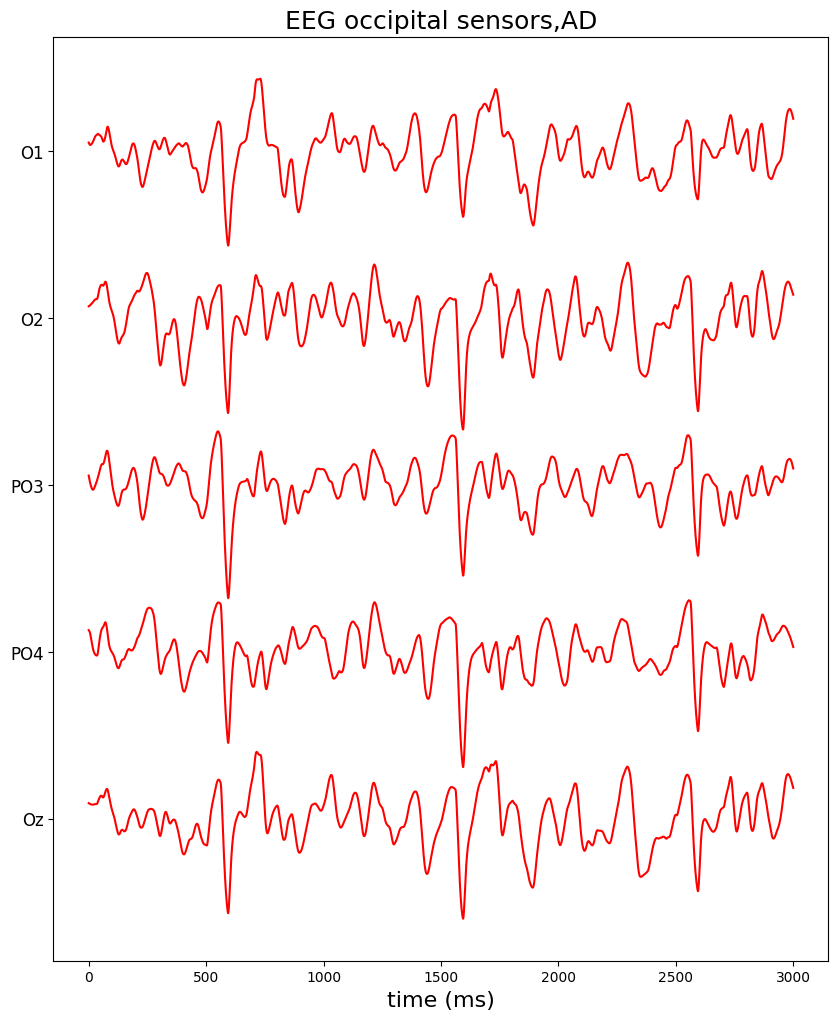

Healthy N1 depth is: -0.6559807668719776
AD N1 depth is: -0.5779955364061379


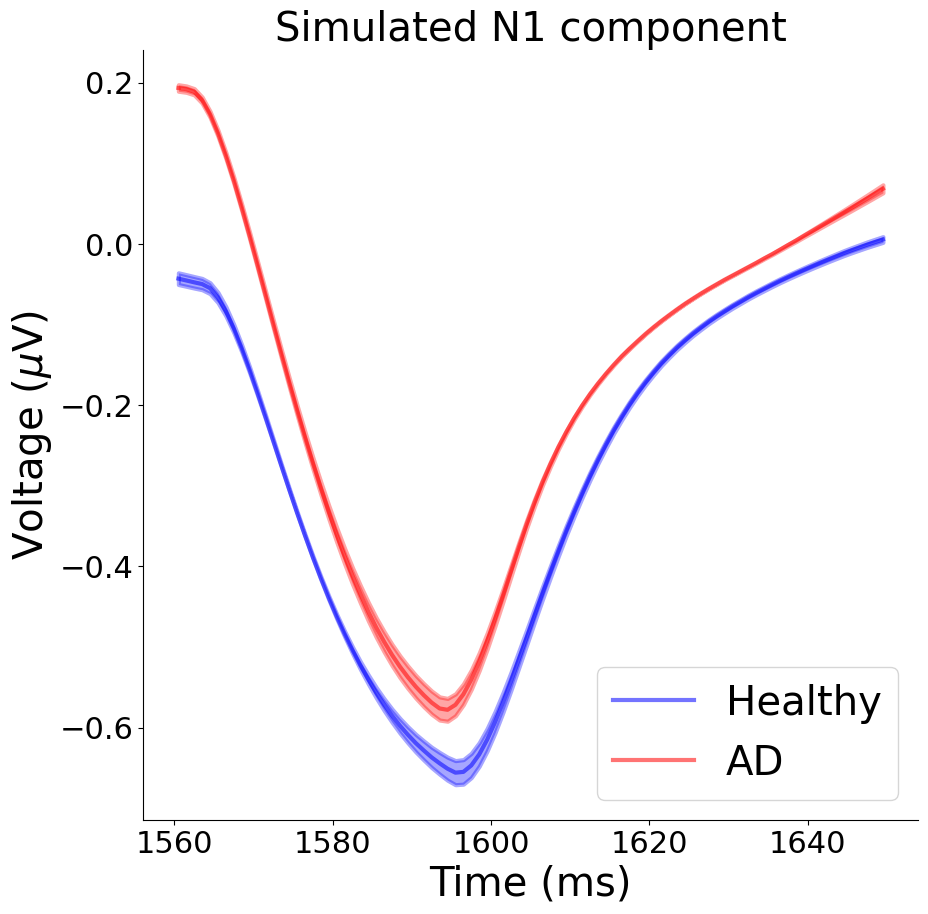

In [15]:
#Load connectivity
conn =  connectivity.Connectivity.from_file('connectivity_76.zip')

#We determine model parameters as explained in the paper (eqs 2 and 3)
n_steps = 50
weightval_arr = np.linspace(0,2,n_steps)
aval_arr = np.linspace(0.100,0.112,n_steps)
bval_arr = np.linspace(0.048,0.025,n_steps)

ttavg_stim, tavg_healthy_stim, teeg_stim, eeg_healthy_stim = Simulate(weightval = weightval_arr[15] , aval = aval_arr[26], bval = bval_arr[26], 
                                                con = conn, stimulus_bool = True, sim_time = 4000) #Less simulated time needed
ttavg_stim, tavg_healthy_stim, teeg_stim, eeg_healthy_stim = preprocess(ttavg_stim, tavg_healthy_stim, teeg_stim, eeg_healthy_stim)


ttavg_stim, tavg_AD_stim, teeg_stim, eeg_AD_stim = Simulate(weightval = weightval_arr[49] , aval = aval_arr[49], bval = bval_arr[49], 
                                                con = conn, stimulus_bool = True, sim_time = 4000) #Less simulated time needed
ttavg_stim, tavg_AD_stim, teeg_stim, eeg_AD_stim = preprocess(ttavg_stim, tavg_AD_stim, teeg_stim, eeg_AD_stim)



datas_stim = {'data_healthy': {'tavg': tavg_healthy_stim, 'eeg': eeg_healthy_stim, 'label': 'Healthy', 'color': 'blue'},
         'data_AD': {'tavg': tavg_AD_stim, 'eeg': eeg_AD_stim,  'label': 'AD', 'color': 'red'}}

#Occipital EEG channels
chlist_occipital = [30,32,33,8,9]
display_time = sim_time - 2000



for key, value in datas_stim.items():
    tavg_stim = value['tavg']
    eeg_stim = value['eeg']
    label = value['label']
    color = value['color']

    #Plot EEG
    figure(figsize=(10,12))
    plot(teeg_stim[:display_time], eeg_stim[:display_time, 0, chlist_occipital, 0] + np.r_[:(len(chlist_occipital))], color = color)
    yticks(np.r_[:len(chlist_occipital)], mon_EEG.sensors.labels[chlist_occipital], fontsize = 12)
    title("EEG occipital sensors," + label, fontsize = 18)
    plt.xlabel('time (ms)', fontsize = 16)
    plt.show()

    
    
################################## USEFUL ONLY WHEN STIMULUS IS APPLIED ###################################################

#1500 is stimulus onset 
mask1 = 1560
mask2  = 1650



chlist_occipital = [30,32,33,8,9]

chlist = chlist_occipital



plt.figure(figsize=(10,10))
for key, value in datas_stim.items():
    
    tavg_stim = value['tavg']
    eeg_stim = value['eeg']
    label = value['label']
    color = value['color']
    
    mean_n1 = mean_channels(mask1,mask2,eeg_stim,chlist)
    std_n1 =  std_channels(mask1,mask2,eeg_stim,chlist)
    
    plt.plot(teeg_stim[mask1:mask2], mean_n1, color = color, linewidth = 3, alpha = 0.55, label =  label)
    plt.fill_between(teeg_stim[mask1:mask2], mean_n1 + std_n1, mean_n1 - std_n1, color = color, linewidth = 3, alpha = 0.35 )
        
    print(label, 'N1 depth is:', np.min(mean_n1))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Simulated N1 component", fontsize = 29)
plt.xlabel('Time (ms)', fontsize = 29)
plt.ylabel(r'Voltage ($\mu$V)', fontsize = 29)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 29)
plt.show()


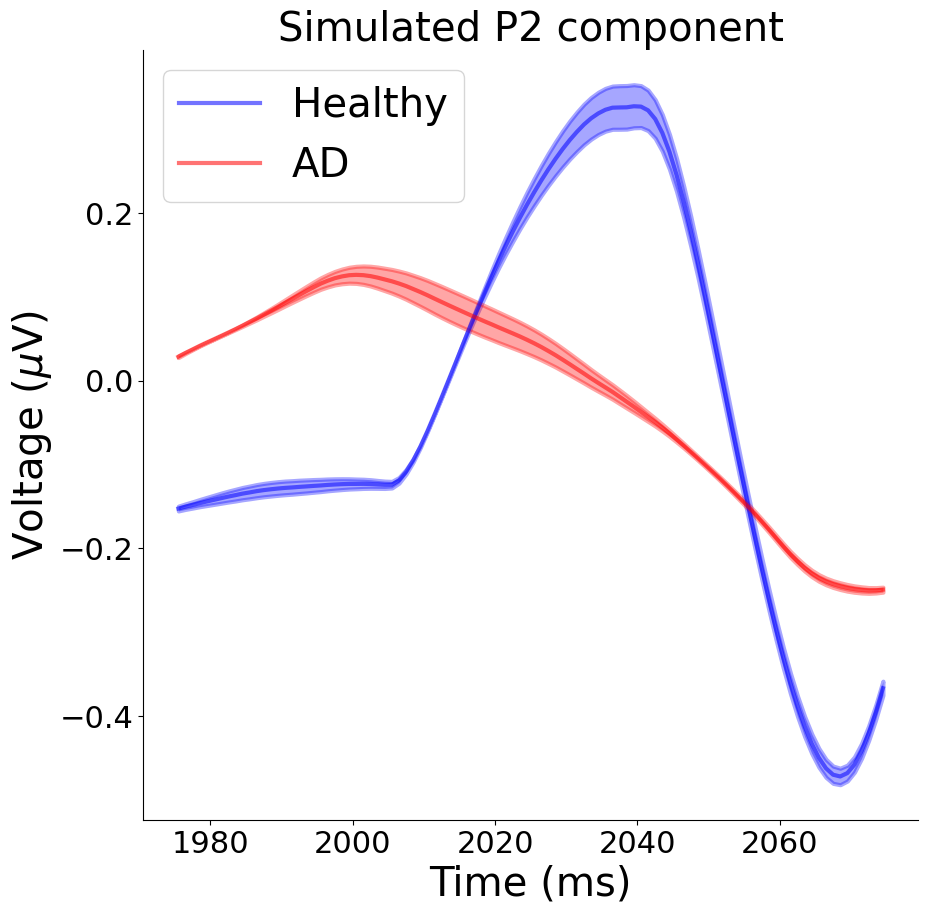

In [16]:
mask1 = 1975
mask2  = 2075
chlist_central = [40,41,53,54,63,64]
chlist = chlist_central

plt.figure(figsize=(10,10))
for key, value in datas_stim.items():
    
    tavg_stim = value['tavg']
    eeg_stim = value['eeg']
    label = value['label']
    color = value['color']
    
    mean_p2 = mean_channels(mask1,mask2,eeg_stim,chlist)
    std_p2 =  std_channels(mask1,mask2,eeg_stim,chlist)
    
    plt.plot(teeg_stim[mask1:mask2], mean_p2, color = color, linewidth = 3, alpha = 0.55, label =  label)
    plt.fill_between(teeg_stim[mask1:mask2], mean_p2 + std_p2, mean_p2 - std_p2, color = color, linewidth = 3, alpha = 0.35 )

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Simulated P2 component", fontsize = 29)
plt.xlabel('Time (ms)', fontsize = 29)
plt.ylabel(r'Voltage ($\mu$V)', fontsize = 29)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 29)
plt.show()